# Combine Signals for Enhanced Alpha

## Packages
When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

The other packages that we're importing are `project_helper`,`factor_pipelines` and `no_overlap_classifier`. These are custom packages built to help you solve the problems.  The `project_helper` module contains utility functions and graph functions.

### Load Packages

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

from zipline.data import bundles
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar
from zipline.data.data_portal import DataPortal

import project_helper
from factors_pipeline import run_data_pipeline
from no_overlap_classifier import NoOverlapVoter,non_overlapping_samples

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import alphalens as al

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

## Data Pipeline
### Data Bundle
We'll be using Zipline to handle our data. We've created a end of day data bundle for this project. Run the cell below to register this data bundle in zipline.

In [2]:
ingest_func = bundles.csvdir.csvdir_equities(['daily'], project_helper.EOD_BUNDLE_NAME)
bundles.register(project_helper.EOD_BUNDLE_NAME, ingest_func)
print('Data Registered')

Data Registered


### Build Pipeline Engine
We'll be using Zipline's pipeline package to access our data for this project. To use it, we must build a pipeline engine. Run the cell below to build the engine.

In [3]:
universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('XBOM') 
bundle_data = bundles.load(project_helper.EOD_BUNDLE_NAME)
engine = project_helper.build_pipeline_engine(bundle_data, trading_calendar)

#### View Data
With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using.

In [4]:
universe_end_date = pd.Timestamp('2020-05-15', tz='UTC')
factor_start_date = universe_end_date - pd.DateOffset(years=3,days=357)

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [3MINDIA.NS]),
 Equity(1 [AARTIIND.NS]),
 Equity(2 [ABBOTINDIA.NS]),
 Equity(3 [ABFRL.NS]),
 Equity(4 [ACC.NS]),
 Equity(5 [ADANIPORTS.NS]),
 Equity(6 [ADANIPOWER.NS]),
 Equity(7 [AEGISCHEM.NS]),
 Equity(8 [AIAENG.NS]),
 Equity(9 [AJANTPHARM.NS]),
 Equity(10 [AKZOINDIA.NS]),
 Equity(11 [ALLCARGO.NS]),
 Equity(12 [AMARAJABAT.NS]),
 Equity(13 [AMBUJACEM.NS]),
 Equity(14 [APLAPOLLO.NS]),
 Equity(15 [APLLTD.NS]),
 Equity(16 [APOLLOHOSP.NS]),
 Equity(17 [APOLLOTYRE.NS]),
 Equity(18 [ASAHIINDIA.NS]),
 Equity(19 [ASHOKA.NS]),
 Equity(20 [ASHOKLEY.NS]),
 Equity(21 [ASIANPAINT.NS]),
 Equity(22 [ASTRAL.NS]),
 Equity(23 [ASTRAZEN.NS]),
 Equity(24 [ATUL.NS]),
 Equity(25 [AUROPHARMA.NS]),
 Equity(26 [AVANTIFEED.NS]),
 Equity(27 [AXISBANK.NS]),
 Equity(28 [BAJAJ-AUTO.NS]),
 Equity(29 [BAJAJCON.NS]),
 Equity(30 [BAJAJELEC.NS]),
 Equity(31 [BAJAJFINSV.NS]),
 Equity(32 [BAJAJHLDNG.NS]),
 Equity(33 [BAJFINANCE.NS]),
 Equity(34 [BALKRISIND.NS]),
 Equity(35 [BALMLAWRIE.NS]),
 Equity(36 [BALRAMCH

### Get Returns
We have our pipeline built, let's access the returns data. We'll start by building a data portal.

To make the code easier to read, we've built the helper function `get_pricing` to get the pricing from the data portal. 

In [5]:
data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)


def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

## Alpha Factors
It's time to start working on the alpha factors. In this project, we'll use the following factors:
- Momentum 1 Year Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Smoothed Factor
- 15/30 Days RSI Of Returns
- RegressionAgainstTime to Compute Beta And Gamma

## Risk Factors
It's time to start working on the risk factors. In this project, we'll use the following factors:
- Sortino Ratio
- 3 Month Volatility

## Features and Labels
Let's create some features that we think will help the model make predictions.
### "Universal" Quant Features
To capture the universe, we'll use the following as features:
- Stock Volatility 20d, 120d
- Stock Dollar Volume 20d, 120d
- Sector

### Regime Features
We are going to try to capture market-wide regimes. To do that, we'll use the following features:
- High and low volatility 20d, 120d
- High and low dispersion 20d, 120d

### Target
Let's try to predict the go forward 1-week return. When doing this, it's important to quantize the target. The factor we create is the trailing 5-day return.

### Date Features
Let's make columns for the trees to split on that might capture trader/investor behavior due to calendar anomalies.

### One Hot Encode Sectors
For the model to better understand the sector data, we'll one hot encode this data.

### Shift Target
We'll use shifted 5 day returns for training the model.

### Computing Factors Mentioned Above :-

In [6]:
all_factors,sector_columns = run_data_pipeline(engine,universe,factor_start_date,universe_end_date)

In [7]:
all_factors.head()

3 Month Volatility  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])               0.024891   
                          Equity(1 [AARTIIND.NS])              0.020729   
                          Equity(2 [ABBOTINDIA.NS])            0.014124   
                          Equity(3 [ABFRL.NS])                 0.034523   
                          Equity(4 [ACC.NS])                   0.014709   

                                                     Downside Risk (Sortino Ratio)  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                          0.156528   
                          Equity(1 [AARTIIND.NS])                         0.144902   
                          Equity(2 [ABBOTINDIA.NS])                       0.106799   
                          Equity(3 [ABFRL.NS])                            0.007969   
                          Equity(4 [ACC.NS])                             -0.009721   

                                                     Mean_Reversion_Sector_Neutral_Smoothed  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                                  -1.249207   
                          Equity(1 [AARTIIND.NS])                                 -0.575876   
                          Equity(2 [ABBOTINDIA.NS])                                0.761928   
                          Equity(3 [ABFRL.NS])                                     0.531577   
                          Equity(4 [ACC.NS])                                       0.416402   

                                                     Momentum_1YR  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])         1.390961   
                          Equity(1 [AARTIIND.NS])        1.506136   
                          Equity(2 [ABBOTINDIA.NS])      0.478420   
                          Equity(3 [ABFRL.NS])           0.336666   
                          Equity(4 [ACC.NS])            -0.097456   

                                                     Overnight_Sentiment_Smoothed  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                        -1.311224   
                          Equity(1 [AARTIIND.NS])                       -1.364382   
                          Equity(2 [ABBOTINDIA.NS])                      0.682191   
                          Equity(3 [ABFRL.NS])                          -0.504999   
                          Equity(4 [ACC.NS])                            -1.151751   

                                                     RSI_Sector_Neutral_15d  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                  -1.107453   
                          Equity(1 [AARTIIND.NS])                 -0.318946   
                          Equity(2 [ABBOTINDIA.NS])                1.116313   
                          Equity(3 [ABFRL.NS])                     1.275786   
                          Equity(4 [ACC.NS])                       0.425262   

                                                     RSI_Sector_Neutral_30d  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                   1.709907   
                          Equity(1 [AARTIIND.NS])                 -0.947980   
                          Equity(2 [ABBOTINDIA.NS])                1.568153   
                          Equity(3 [ABFRL.NS])                     0.434122   
                          Equity(4 [ACC.NS])                      -0.939120   

                                                     adv_120d   adv_20d  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])    -0.965699 -1.196049   
                          Equity(1 [AARTIIND.NS])   -0.930261 -0.584735   
                          Equity(2 [ABBOTINDIA.NS]) -1.009997 -1.470698   
                          Equity(3 [ABFRL.NS])       0.327806 -0.177192   
                          Equity(4 [ACC.NS])         0.815085  0.894822   

                                                     conditional_factor  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])              -1.647890   
                          Equity(1 [A

### Train/Valid/Test Splits
Now let's split the data into a train, validation, and test dataset. Implement the function `train_valid_test_split` to split the input samples, `all_x`, and targets values, `all_y` into a train, validation, and test dataset. The proportion sizes are `train_size`, `valid_size`, `test_size` respectively.

When splitting, make sure the data is in order from train, validation, and test respectivly. Say `train_size` is 0.7, `valid_size` is 0.2, and `test_size` is 0.1. The first 70 percent of `all_x` and `all_y` would be the train set. The next 20 percent of `all_x` and `all_y` would be the validation set. The last 10 percent of `all_x` and `all_y` would be the test set. Make sure not split a day between multiple datasets. It should be contained within a single dataset.

In [8]:
def train_valid_test_split(all_x, all_y, train_size, valid_size, test_size):
    """
    Generate the train, validation, and test dataset.

    Parameters
    ----------
    all_x : DataFrame
        All the input samples
    all_y : Pandas Series
        All the target values
    train_size : float
        The proportion of the data used for the training dataset
    valid_size : float
        The proportion of the data used for the validation dataset
    test_size : float
        The proportion of the data used for the test dataset

    Returns
    -------
    x_train : DataFrame
        The train input samples
    x_valid : DataFrame
        The validation input samples
    x_test : DataFrame
        The test input samples
    y_train : Pandas Series
        The train target values
    y_valid : Pandas Series
        The validation target values
    y_test : Pandas Series
        The test target values
    """
    assert train_size >= 0 and train_size <= 1.0
    assert valid_size >= 0 and valid_size <= 1.0
    assert test_size >= 0 and test_size <= 1.0
    assert train_size + valid_size + test_size == 1.0
    
    # TODO: Implement
    train_end_index = int(len(all_x.index.levels[0].tolist())*train_size)
    valid_end_index = train_end_index + int(len(all_x.index.levels[0].tolist())*valid_size)
    test_end_index = valid_end_index + int(len(all_x.index.levels[0].tolist())*test_size)
    
    x_train,y_train = all_x.loc[all_x.index.levels[0].tolist()[:train_end_index]],all_y.loc[all_y.index.levels[0].tolist()[:train_end_index]]
    x_valid,y_valid = all_x.loc[all_x.index.levels[0].tolist()[train_end_index:valid_end_index]],all_y.loc[all_y.index.levels[0].tolist()[train_end_index:valid_end_index]]
    x_test,y_test = all_x.loc[all_x.index.levels[0].tolist()[valid_end_index:test_end_index]],all_y.loc[all_y.index.levels[0].tolist()[valid_end_index:test_end_index]]

    return x_train, x_valid, x_test, y_train, y_valid, y_test


With `train_valid_test_split` implemented, let's split the data into a train, validation, and test set. For this, we'll use some of the features and the 5 day returns for our target.

In [9]:
features = [
    'Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR',
    'RSI_Sector_Neutral_15d','RSI_Sector_Neutral_30d',
    '3 Month Volatility','Downside Risk (Sortino Ratio)',
    'time_beta','time_gamma','conditional_factor',
    'Overnight_Sentiment_Smoothed', 'adv_120d', 'adv_20d',
    'dispersion_120d', 'dispersion_20d', 'market_vol_120d',
    'market_vol_20d', 'volatility_20d',
    'is_March', 'is_April', 'weekday',
    'month_end', 'month_start', 'qtr_end', 'qtr_start'] + sector_columns
target_label = 'target'

temp = all_factors.dropna().copy()
X = temp[features]
y = temp[target_label]

X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y, 0.6, 0.2, 0.2)

X_train.head()

Mean_Reversion_Sector_Neutral_Smoothed  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                                  -1.249207   
                          Equity(1 [AARTIIND.NS])                                 -0.575876   
                          Equity(2 [ABBOTINDIA.NS])                                0.761928   
                          Equity(3 [ABFRL.NS])                                     0.531577   
                          Equity(4 [ACC.NS])                                       0.416402   

                                                     Momentum_1YR  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])         1.390961   
                          Equity(1 [AARTIIND.NS])        1.506136   
                          Equity(2 [ABBOTINDIA.NS])      0.478420   
                          Equity(3 [ABFRL.NS])           0.336666   
                          Equity(4 [ACC.NS])            -0.097456   

                                                     RSI_Sector_Neutral_15d  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                  -1.107453   
                          Equity(1 [AARTIIND.NS])                 -0.318946   
                          Equity(2 [ABBOTINDIA.NS])                1.116313   
                          Equity(3 [ABFRL.NS])                     1.275786   
                          Equity(4 [ACC.NS])                       0.425262   

                                                     RSI_Sector_Neutral_30d  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                   1.709907   
                          Equity(1 [AARTIIND.NS])                 -0.947980   
                          Equity(2 [ABBOTINDIA.NS])                1.568153   
                          Equity(3 [ABFRL.NS])                     0.434122   
                          Equity(4 [ACC.NS])                      -0.939120   

                                                     3 Month Volatility  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])               0.024891   
                          Equity(1 [AARTIIND.NS])              0.020729   
                          Equity(2 [ABBOTINDIA.NS])            0.014124   
                          Equity(3 [ABFRL.NS])                 0.034523   
                          Equity(4 [ACC.NS])                   0.014709   

                                                     Downside Risk (Sortino Ratio)  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                          0.156528   
                          Equity(1 [AARTIIND.NS])                         0.144902   
                          Equity(2 [ABBOTINDIA.NS])                       0.106799   
                          Equity(3 [ABFRL.NS])                            0.007969   
                          Equity(4 [ACC.NS])                             -0.009721   

                                                     time_beta  time_gamma  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])      1.718767   -1.674469   
                          Equity(1 [AARTIIND.NS])     1.231488   -1.098593   
                          Equity(2 [ABBOTINDIA.NS])   1.709907   -1.718767   
                          Equity(3 [ABFRL.NS])        1.142891   -1.258067   
                          Equity(4 [ACC.NS])         -1.559294    1.603592   

                                                     conditional_factor  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])              -1.647890   
                          Equity(1 [AARTIIND.NS])             -0.717630   
                          Equity(2 [ABBOTINDIA.NS])           -1.701048   
                          Equity(3 [ABFRL.NS])                -0.797366   
                          Equity(4 [ACC.NS])                  -1.435259   

                                                     Overnight_Sentiment_Smoothed  \
2016-05-23 00:00:00+00:00 Equity(0 [3MINDIA.NS])                        -1.311224   
                          Equity(1 [AARTIIND.NS])          

In [10]:
i = 1
print('Features :')
for value in X_train.columns.values:
    print('{}. {}'.format(i,value))
    i += 1

Features :
1. Mean_Reversion_Sector_Neutral_Smoothed
2. Momentum_1YR
3. RSI_Sector_Neutral_15d
4. RSI_Sector_Neutral_30d
5. 3 Month Volatility
6. Downside Risk (Sortino Ratio)
7. time_beta
8. time_gamma
9. conditional_factor
10. Overnight_Sentiment_Smoothed
11. adv_120d
12. adv_20d
13. dispersion_120d
14. dispersion_20d
15. market_vol_120d
16. market_vol_20d
17. volatility_20d
18. is_March
19. is_April
20. weekday
21. month_end
22. month_start
23. qtr_end
24. qtr_start
25. sector_SERVICES
26. sector_CEMENT & CEMENT PRODUCTS
27. sector_INDUSTRIAL MANUFACTURING
28. sector_METALS
29. sector_FINANCIAL SERVICES
30. sector_CHEMICALS
31. sector_PHARMA
32. sector_OIL & GAS
33. sector_POWER
34. sector_CONSUMER GOODS
35. sector_IT
36. sector_AUTOMOBILE
37. sector_HEALTHCARE SERVICES
38. sector_CONSTRUCTION
39. sector_FERTILISERS & PESTICIDES
40. sector_TELECOM
41. sector_MEDIA & ENTERTAINMENT
42. sector_TEXTILES
43. sector_PAPER


### Factor Names To Compare Against AI Alpha
Let's compare our AI Alpha factor to a few other factors. We'll use the following:

In [11]:
factor_names = [
    'Mean_Reversion_Sector_Neutral_Smoothed',
    'Momentum_1YR',
    'Overnight_Sentiment_Smoothed',
    'time_beta',
    '3 Month Volatility',
    'Downside Risk (Sortino Ratio)']

### Model Results
Let's look at some additional metrics to see how well a model performs. We've created the function `show_sample_results` to show the following results of a model:
- Sharpe Ratios
- Factor Returns
- Factor Rank Autocorrelation

In [12]:
all_assets = all_factors.index.levels[1].values.tolist()
all_pricing = get_pricing(data_portal,trading_calendar,all_assets,factor_start_date,universe_end_date)

In [13]:
def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'AI_ALPHA'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = project_helper.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = project_helper.get_factor_returns(factor_data)
    sharpe_ratio = project_helper.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    project_helper.plot_factor_returns(factor_returns)
    project_helper.plot_factor_rank_autocorrelation(factor_data)

# Modelling And Evaluation

## Random Forests
### Checking a Simple Tree
Let's see how a single tree would look using our data.

In [14]:
# This is to get consistent results between each run.
clf_random_state = 0

simple_clf = DecisionTreeClassifier(
    max_depth=3,
    criterion='entropy',
    random_state=clf_random_state)

simple_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

### Train Random Forests with Different Tree Sizes
Let's build models using different tree sizes to find the model that best generalizes.
#### Parameters
When building the models, we'll use the following parameters.

In [15]:
n_days = 10
n_stocks = 400

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks * n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}

n_trees_l = [50, 100, 250, 500, 1000]

We’ll choose a min_samples_leaf parameter to be small enough to allow the tree to fit the data with as much detail as possible, but not so much that it overfits.  We can first propose 500, which is the number of assets in the estimation universe. Since we have about 500 stocks in the stock universe, we’ll want at least 500 stocks in a leaf for the leaf to make a prediction that is representative.  It’s common to multiply this by 2,3,5 or 10, so we’d have min samples leaf of 500, 1000, 1500, 2500, and 5000. If we were to try these values, we’d notice that the model is “too good to be true” on the training data.  A good rule of thumb for what is considered “too good to be true”, and therefore a sign of overfitting, is if the sharpe ratio is greater than 4.  Based on this, we recommend using min_sampes_leaf of 10 * 500, or 5,000.

Feel free to try other values for these parameters, but also keep in mind that making too many small adjustments to hyper-parameters can lead to overfitting even the validation data, and therefore lead to less generalizable performance on the out-of-sample test set.  So when trying different parameter values, choose values that are different enough in scale (i.e. 10, 20, 100 instead of 10,11,12).

In [16]:
train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|██████████| 5/5 [05:19<00:00, 63.85s/Model]


Let's look at the accuracy of the classifiers over the number of trees.

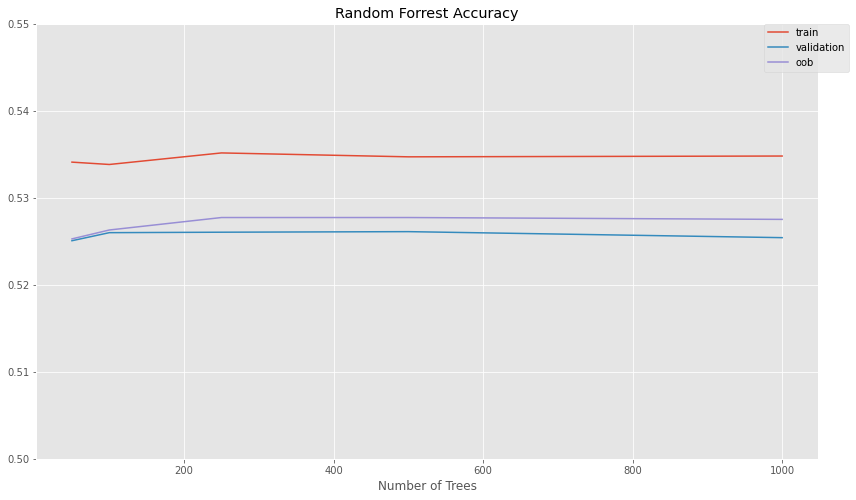

In [17]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

##### Training Prediction
Let's see how well the model runs on training data.

Cleaning Data...

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

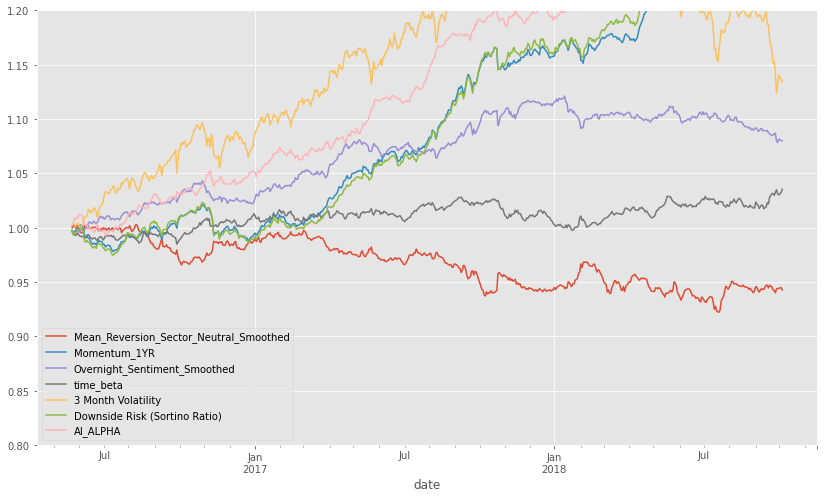

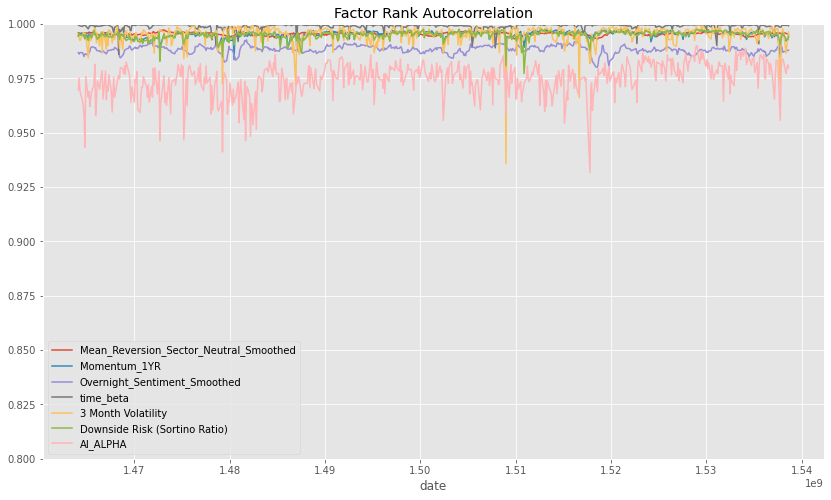

In [18]:
show_sample_results(all_factors, X_train, clf, factor_names)

##### Validation Prediction
Let's see how well the model runs on validation data.

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

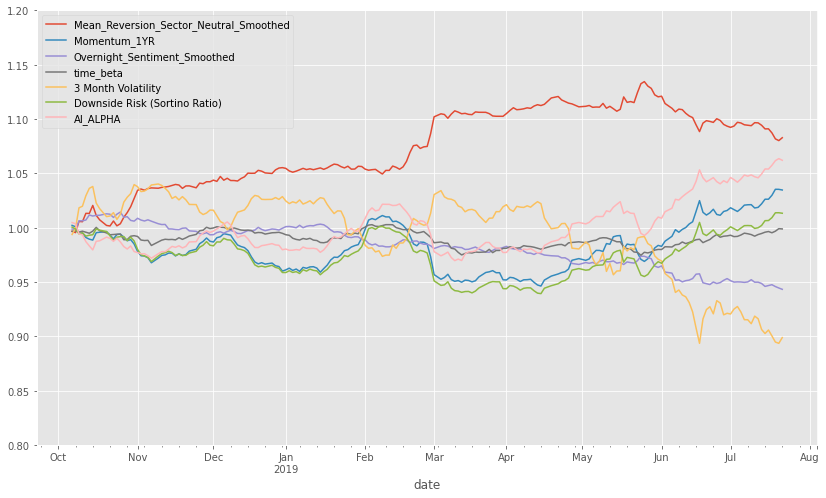

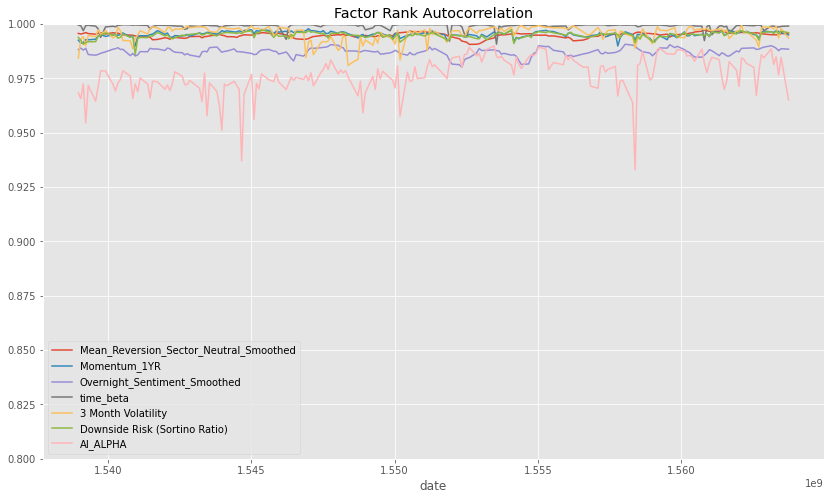

In [19]:
show_sample_results(all_factors, X_valid, clf, factor_names)

So that's pretty extraordinary. Even when the input factor returns are sideways to down, the AI Alpha is positive with Sharpe Ratio > 2. If we hope that this model will perform well in production we need to correct though for the non-IID labels and mitigate likely overfitting.

## Overlapping Samples
Let's fix this by removing overlapping samples. We can do a number of things:

- Don't use overlapping samples
- Build an ensemble of non-overlapping trees

In this project, we'll do all two methods and compare.
### Drop Overlapping Samples
This is the simplest of the three methods. We'll just drop any overlapping samples from the dataset. Implement the `non_overlapping_samples` function to return a new dataset overlapping samples. 

With the dataset created without overlapping samples, lets train a new model and look at the results.

#### Train Model

In [20]:
train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(*non_overlapping_samples(X_train, y_train, 4))
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|██████████| 5/5 [00:51<00:00, 10.24s/Model]


#### Results

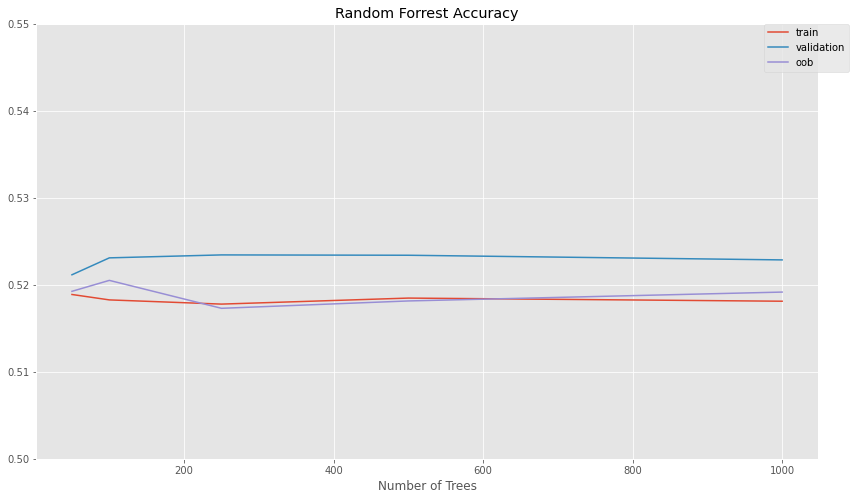

In [21]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

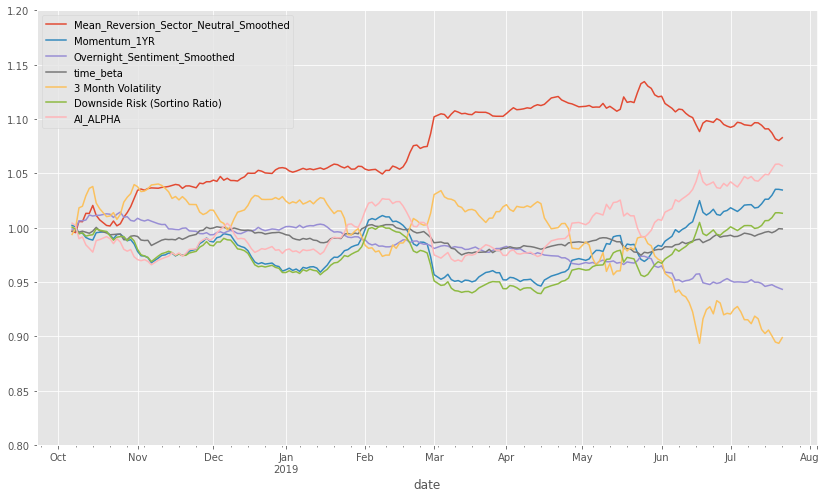

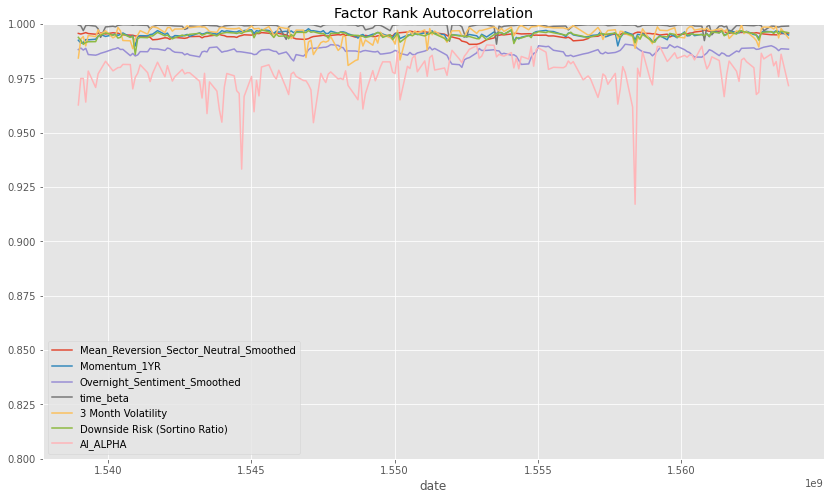

In [22]:
show_sample_results(all_factors, X_valid, clf, factor_names)

This looks better, but we are throwing away a lot of information by taking every 5th row.

### Build an ensemble of non-overlapping trees
The last method is to create ensemble of non-overlapping trees. Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

#### Non Overlapping Estimators
With `calculate_oob_score` implemented, let's create non overlapping estimators. Implement `non_overlapping_estimators` to build non overlapping subsets of the data, then run a estimator on each subset of data.

Now that we have our `NoOverlapVoter` class, let's train it.

#### Train Model

In [23]:
train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models: 100%|██████████| 5/5 [04:14<00:00, 50.90s/Model]


#### Results

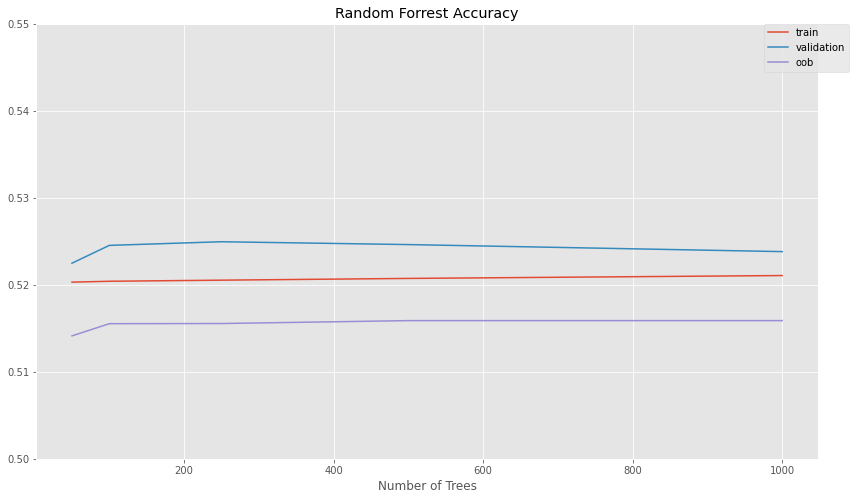

In [24]:
project_helper.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

#### Train :

Cleaning Data...

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

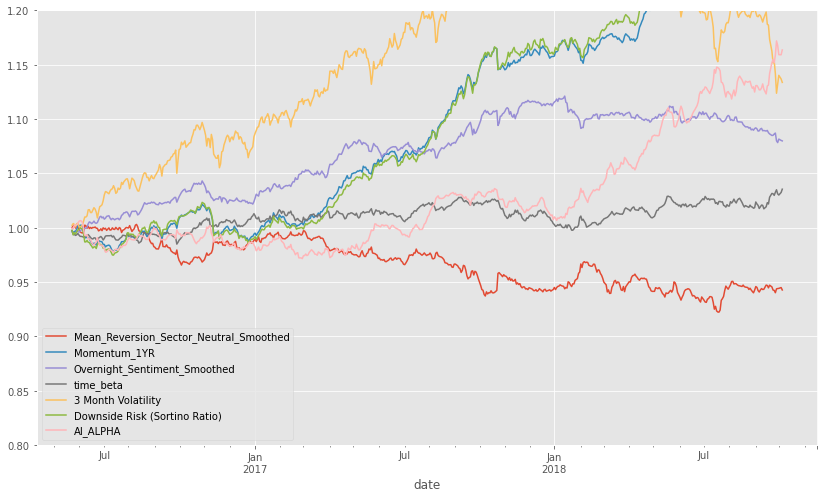

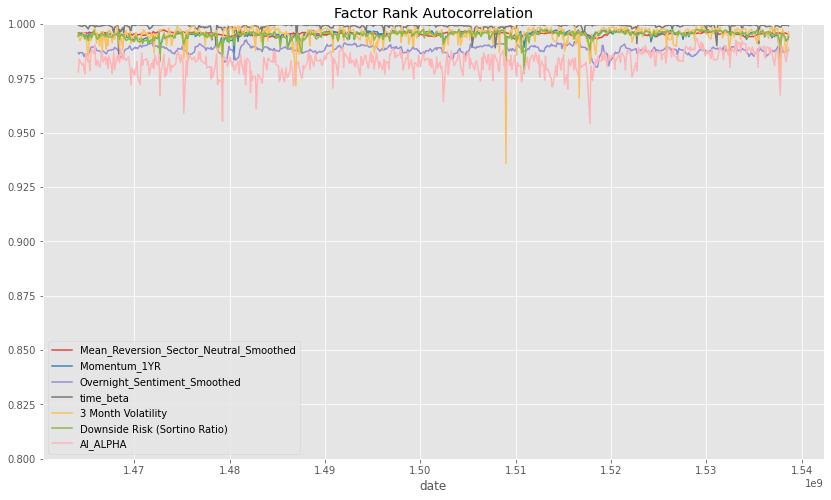

In [25]:
show_sample_results(all_factors, X_train, clf_nov, factor_names)

#### Validation

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

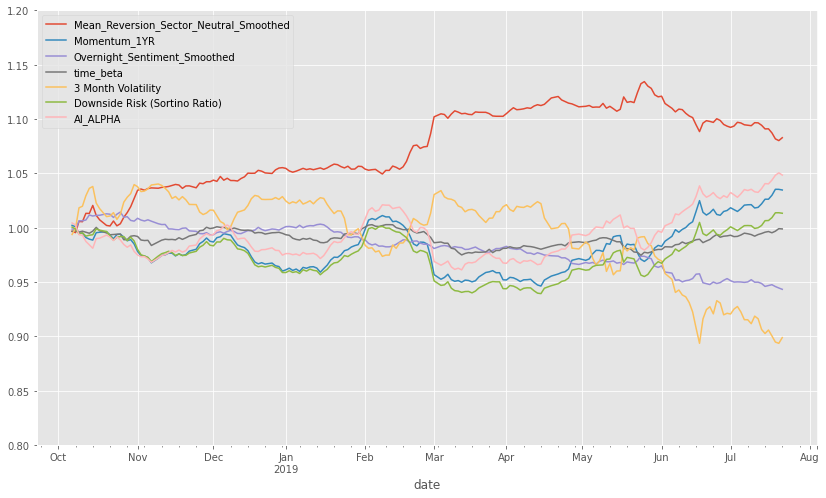

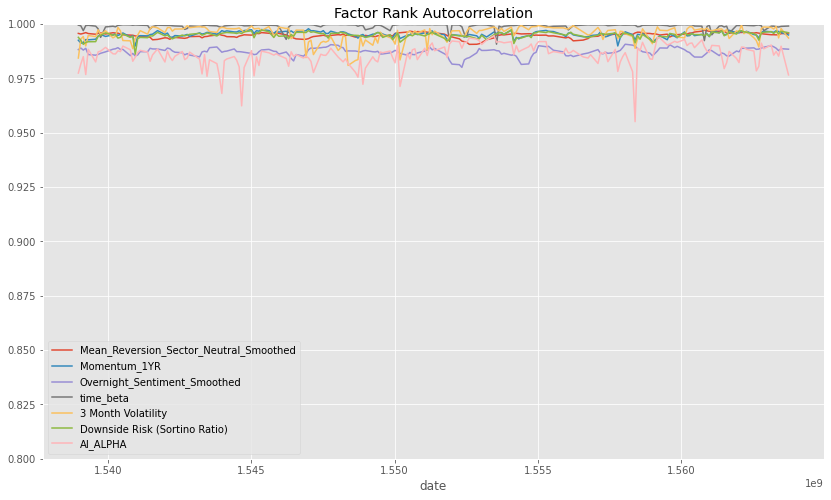

In [26]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [27]:
n_trees = 500

clf = RandomForestClassifier(n_trees, **clf_parameters)
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

NoOverlapVoter(estimator=None)

### Results
#### Accuracy

In [28]:
print('train: {}, oob: {}, valid: {}'.format(
    clf_nov.score(X_train, y_train.values),
    clf_nov.score(X_valid, y_valid.values),
    clf_nov.oob_score_))

train: 0.5190010101361943, oob: 0.5297709923664122, valid: 0.5169482382803925


#### Train

Cleaning Data...

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

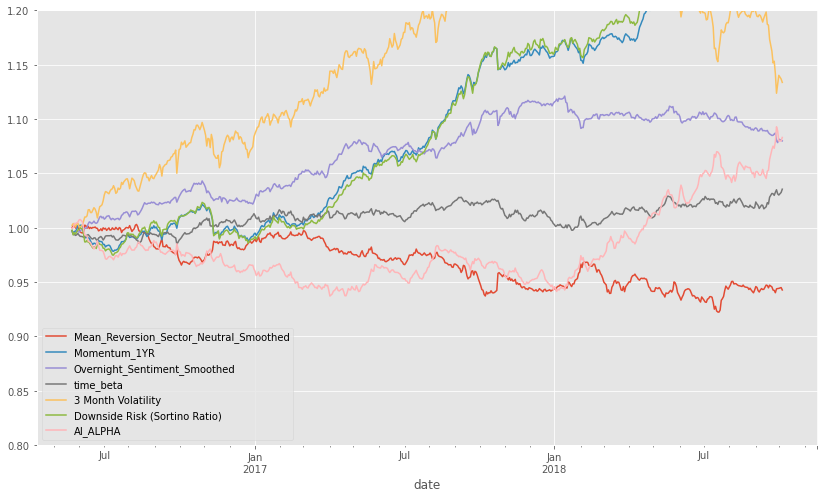

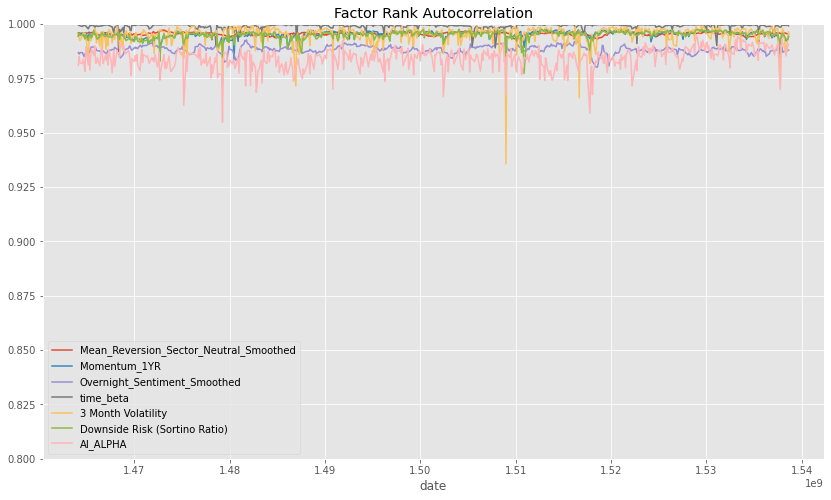

In [29]:
show_sample_results(all_factors, X_train, clf_nov, factor_names)

#### Validation

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

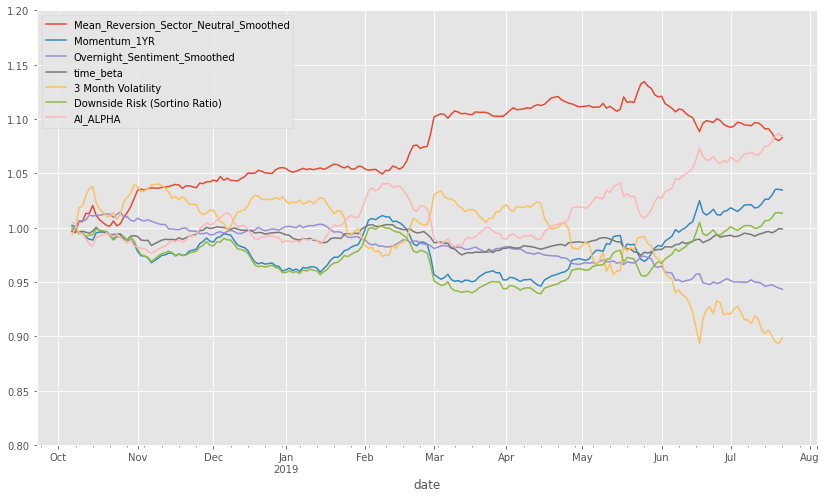

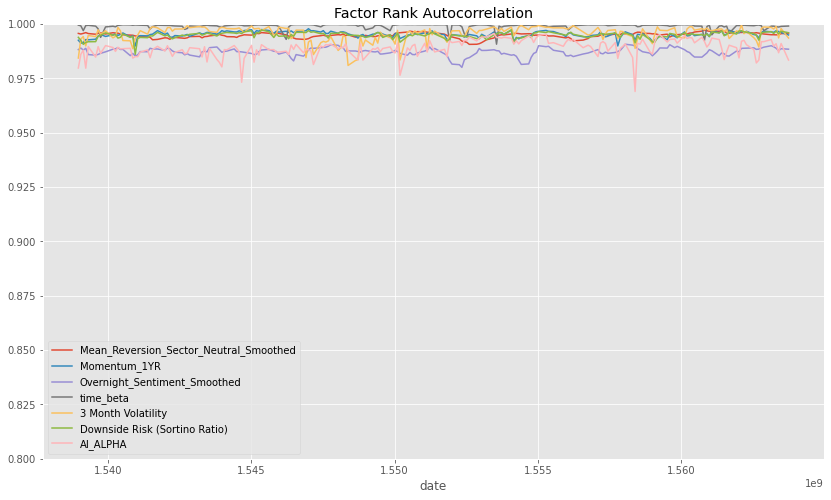

In [30]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names)

#### Test

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

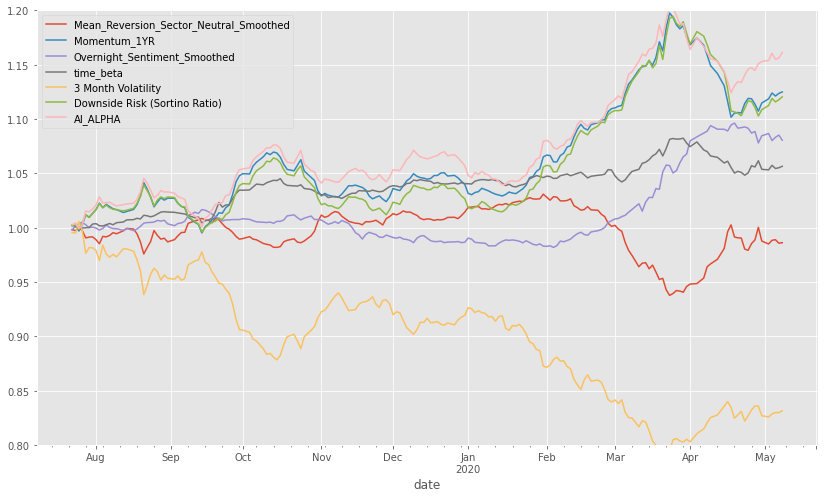

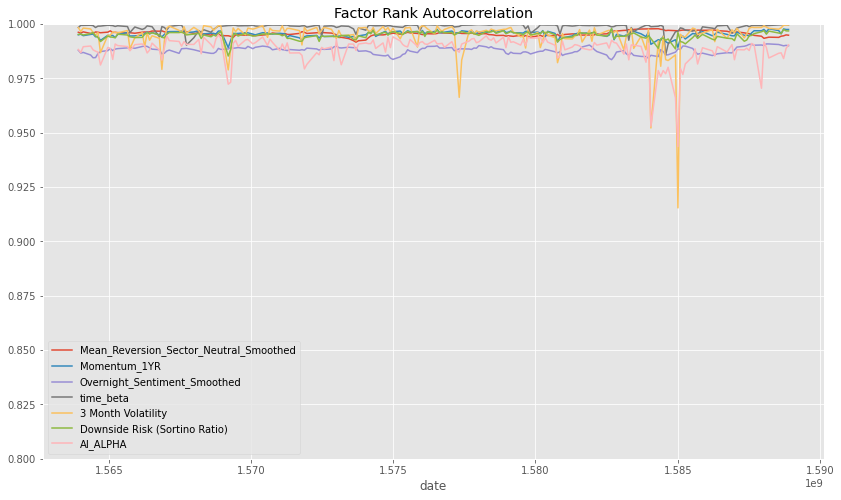

In [31]:
show_sample_results(all_factors, X_test, clf_nov, factor_names)

Despite the significant differences between the factor performances in the three sets, the AI APLHA is able to deliver positive performance.